In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle
import inspect

In [2]:
def random_forest(train_X, train_y, test_X, n_estimators=10, min_samples_leaf=5, criterion='entropy', print_model_details=False, gridsearch=True, save_model=False):

    if gridsearch:
        tuned_parameters = [{'min_samples_leaf': [2, 10, 50, 100, 200],
                             'n_estimators':[10, 50, 100],
                             'criterion':['gini', 'entropy']}]
        rf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, scoring='accuracy', error_score= 'raise')
    else:
        rf = RandomForestClassifier(n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, criterion=criterion)

    # Fit the model

    rf.fit(train_X, train_y.values.ravel())

    if gridsearch and print_model_details:
        print(rf.best_params_)

    if gridsearch:
        rf = rf.best_estimator_

    pred_prob_training_y = rf.predict_proba(train_X)
    pred_prob_test_y = rf.predict_proba(test_X)
    pred_training_y = rf.predict(train_X)
    pred_test_y = rf.predict(test_X)
    frame_prob_training_y = pd.DataFrame(pred_prob_training_y, columns=rf.classes_)
    frame_prob_test_y = pd.DataFrame(pred_prob_test_y, columns=rf.classes_)

    if print_model_details:
        ordered_indices = [i[0] for i in sorted(enumerate(rf.feature_importances_), key=lambda x:x[1], reverse=True)]
        print('Top 20 feature importances random forest:')
        for i in range(0, 20):
            print(train_X.columns[ordered_indices[i]], end='')
            print(' & ', end='')
            print(rf.feature_importances_[ordered_indices[i]])
    
    if save_model:
        # save the model to disk
        filename = 'final_' + str(inspect.stack()[0][3]) + '_model_BCI.sav'
        pickle.dump(rf, open(filename, 'wb'))

    return pred_training_y, pred_test_y, frame_prob_training_y, frame_prob_test_y

In [3]:
DRUNK_PATH = Path('./Dataset/step3_result/drunk/')
NONDRUNK_PATH = Path('./Dataset/step3_result/non_drunk/')
# all_drunk_dataset = pd.read_csv('./Dataset/step3_result/concatenated/drunk.csv')
# all_nondrunk_dataset = pd.read_csv('./Dataset/step3_result/concatenated/nondrunk.csv')

In [4]:
# Creating a merged Drunk and Non-drunk dataframe seperately 
WINDOW_SIZE = 50

all_drunk_dataset = []
all_nondrunk_dataset = []

for instance in os.scandir(DRUNK_PATH): 
    instance_path = instance.path
    dataset = pd.read_csv(instance_path, index_col=0)
    dataset.index = pd.to_datetime(dataset.index)
    dataset = dataset.drop(columns='check')
    all_drunk_dataset.append(dataset)

for instance in os.scandir(NONDRUNK_PATH): 
    instance_path = instance.path
    dataset = pd.read_csv(instance_path, index_col=0)
    dataset.index = pd.to_datetime(dataset.index)
    dataset = dataset.drop(columns='check')
    all_nondrunk_dataset.append(dataset)

In [5]:
# Data manipulation into interval of 5 seconds
X = []
y = []

# sum1 = 0
# sum2 = 0

for i in range (len(all_drunk_dataset)):
    df = all_drunk_dataset[i].to_numpy()
    # print(len(df))
    # sum1 += len(df)
    # for j in range (0,len(df) - WINDOW_SIZE):
    #     col = [a for a in df[j:j+WINDOW_SIZE]]
    #     X.append(col)
    #     y.append(1)

for i in range (len(all_nondrunk_dataset)):
    df = all_nondrunk_dataset[i].to_numpy()
    # print(len(df))
    # sum2 += len(df)
    # for j in range (0,len(df) - WINDOW_SIZE):
    #     col = [a for a in df[j:j+WINDOW_SIZE]]
    #     X.append(col)
    #     y.append(0)
    
X_df = pd.DataFrame(data=X)
y_df = pd.DataFrame(data=y)
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

In [6]:
# # Data manipulation from regular train test split
drunk_df = pd.read_csv('./Dataset/step3_result/concatenated/drunk.csv')
nondrunk_df = pd.read_csv('./Dataset/step3_result/concatenated/nondrunk.csv')

drunk_df = drunk_df.dropna(axis=0)
nondrunk_df = nondrunk_df.dropna(axis=0)

y_drunk = drunk_df['check']
X_drunk = drunk_df.drop(columns='check')
X_drunk = X_drunk.drop(columns=X_drunk.columns[0])

y_nondrunk = nondrunk_df['check']
X_nondrunk = nondrunk_df.drop(columns='check')
X_nondrunk = X_nondrunk.drop(columns=X_nondrunk.columns[0])

X_drunk, y_drunk = X_drunk[:2500], y_drunk[:2500]
X_nondrunk, y_nondrunk = X_nondrunk[:2500], y_nondrunk[:2500]

X_train_drunk, X_test_drunk, y_train_drunk, y_test_drunk = train_test_split(X_drunk, y_drunk, test_size=0.2)
# X_train_drunk, X_val_drunk, y_train_drunk, y_val_drunk = train_test_split(X_train_drunk, y_train_drunk, test_size=0.25) #split train and validation dataset

X_train_nondrunk, X_test_nondrunk, y_train_nondrunk, y_test_nondrunk = train_test_split(X_nondrunk, y_nondrunk, test_size=0.2)
# X_train_nondrunk, X_val_nondrunk, y_train_nondrunk, y_val_nondrunk = train_test_split(X_train_nondrunk, y_train_nondrunk, test_size=0.25)

X_train = pd.concat([X_train_drunk, X_train_nondrunk])
X_test = pd.concat([X_test_drunk, X_test_nondrunk])
# X_val = pd.concat([X_val_drunk, X_val_nondrunk])
y_train = pd.concat([y_train_drunk, y_train_nondrunk])
y_test = pd.concat([y_test_drunk, y_test_nondrunk])
# y_val = pd.concat([y_val_drunk, y_val_nondrunk])

print(np.shape(X_train),np.shape(y_train))
print(np.shape(X_test),np.shape(y_test))

(4000, 584) (4000,)
(1000, 584) (1000,)


In [7]:
from Step_4_MLmodels.Evaluation import ClassificationEvaluation
class_train_y, class_test_y, class_train_prob_y, class_test_prob_y = random_forest(
                train_X=X_train, train_y=y_train, test_X=X_test, gridsearch=False, print_model_details=True, save_model=True,
            )
eval = ClassificationEvaluation()
performance_training_rf_final = eval.f1(y_train, class_train_y)
performance_test_rf_final = eval.f1(y_test, class_test_y)

print(performance_test_rf_final) #test performance is reasonable!

Top 20 feature importances random forest:
Gamma_TP9_temp_mean_ws_20 & 0.13072819455221846
Gamma_AF8_temp_mean_ws_30 & 0.0661394616603207
Gamma_TP9_temp_max_ws_10 & 0.05171186994532885
Delta_AF8_temp_std_ws_30 & 0.03279740135253473
Gamma_TP9_temp_mean_ws_30 & 0.030542140234361397
Beta_TP9_temp_mean_ws_30 & 0.030541436267873118
Gamma_TP10_temp_min_ws_20 & 0.028014367640840965
Gamma_AF8_temp_median_ws_20 & 0.027049285236559906
Beta_TP9_temp_min_ws_20 & 0.02675733712316289
Gamma_TP9_temp_max_ws_30 & 0.026402748415998257
Gamma_TP9_temp_min_ws_10 & 0.025387960188237507
Gamma_TP9 & 0.025104907419105937
Gamma_TP9_temp_max_ws_20 & 0.023970790974167617
Delta_AF7_temp_std_ws_30 & 0.020887294934151545
Gamma_TP9_temp_median_ws_30 & 0.020701298945249358
Theta_AF8_temp_std_ws_30 & 0.020429616984370787
Gamma_TP10_temp_max_ws_30 & 0.01891583926833036
Gamma_TP9_temp_min_ws_20 & 0.018709628006189836
Beta_TP9_temp_median_ws_30 & 0.01809030000232734
Beta_TP10_temp_min_ws_30 & 0.014277770359501276
0.9969999

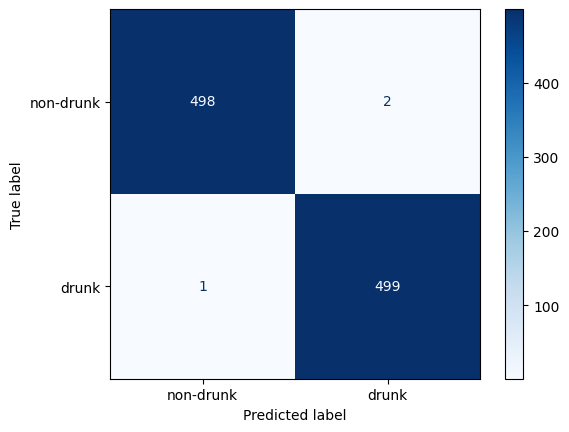

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
confusionmatrix_rf_final = eval.confusion_matrix(y_test, class_test_y, labels=[0,1])
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusionmatrix_rf_final, display_labels = ["non-drunk", "drunk"])
  
cm_display.plot(cmap="Blues")
plt.show()
cm_display.figure_.savefig('rf_confusion_matrix.png')

In [9]:
print("Accuracy:", accuracy_score(y_test, class_test_y))
print("Precision:" , precision_score(y_test, class_test_y))
print("Recall: ", recall_score(y_test, class_test_y))
print("F1 Score: ", f1_score(y_true=y_test, y_pred=class_test_y))

Accuracy: 0.997
Precision: 0.9960079840319361
Recall:  0.998
F1 Score:  0.997002997002997
